In [1]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num , DateFormatter
import datetime as dt
import quandl as q
q.ApiConfig.api_key = '88Yx6sJ8EDQzCQZw427L'

In [2]:
def get(tickers, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2006, 10, 1), datetime.datetime(2021, 1, 1))

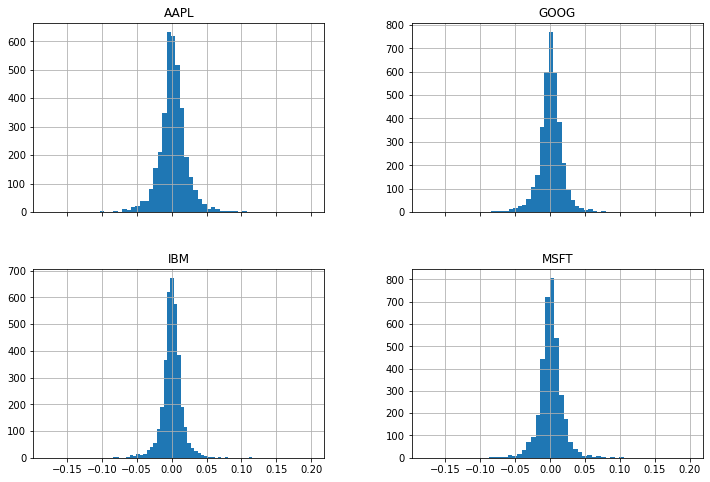

In [3]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Isolate the `Adj Close` values and transform the DataFrame
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

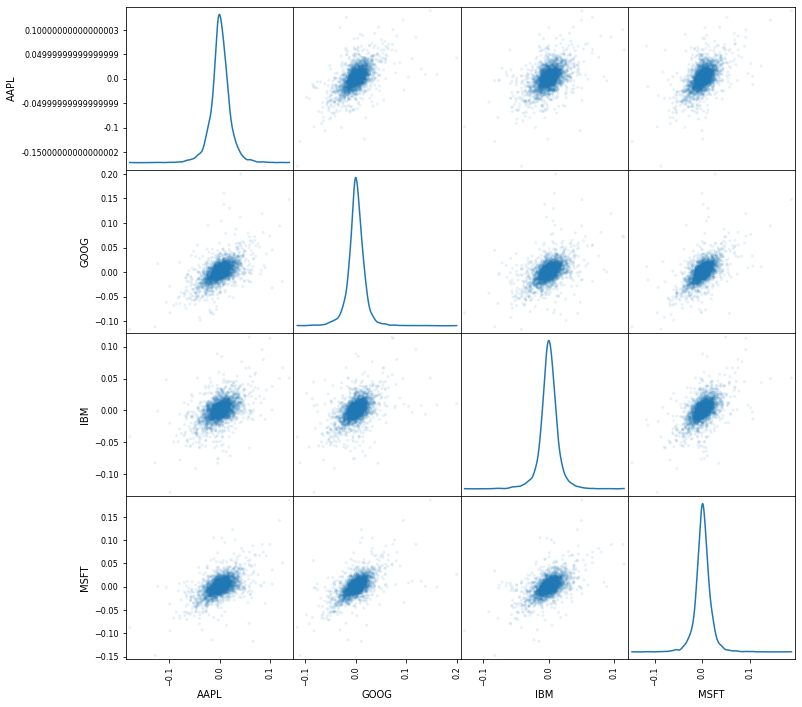

In [4]:
# Import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


# Plot a scatter matrix with the `daily_pct_change` data 
scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))

# Show the plot
plt.show()

In [8]:
aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2006, 10, 1), 
                          end=datetime.datetime(2021, 1, 1))
# Isolate the adjusted closing prices 
adj_close_px = aapl['Adj Close']

# Calculate the moving average
moving_avg = adj_close_px.rolling(window=40).mean()

# Inspect the result
print(moving_avg[-10:])

Date
2020-12-17    118.622635
2020-12-18    118.900369
2020-12-21    119.235072
2020-12-22    119.660776
2020-12-23    120.024796
2020-12-24    120.548834
2020-12-28    121.088050
2020-12-29    121.742987
2020-12-30    122.371420
2020-12-31    122.932425
Name: Adj Close, dtype: float64


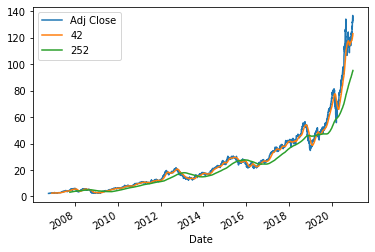

In [9]:
# Import matplotlib 
import matplotlib.pyplot as plt

# Short moving window rolling mean
aapl['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
aapl['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', '42', '252']].plot()

# Show plot
plt.show()

In [10]:
adj_close_px.head()

Date
2006-10-02    2.306359
2006-10-03    2.282328
2006-10-04    2.322379
2006-10-05    2.305435
2006-10-06    2.286641
Name: Adj Close, dtype: float64

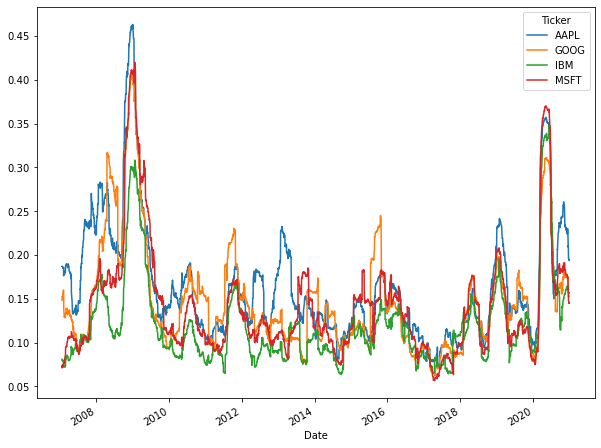

In [17]:
#Volatility Calculation
#Generally, the higher the volatility, the riskier the investment in that stock, 
#which results in investing in one over another

# Import matplotlib
import matplotlib.pyplot as plt 

# Define the minumum of periods to consider 
min_periods = 75

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

In [23]:
# Import the `api` model of `statsmodels` under alias `sm`
import statsmodels.api as sm

# Import the `datetools` module from `pandas`
#from pandas.core import datetools

# Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

# Calculate the returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

# Isolate the AAPL returns 
aapl_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'AAPL']
aapl_returns.index = aapl_returns.index.droplevel('Ticker')

# Isolate the MSFT returns
msft_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'MSFT']
msft_returns.index = msft_returns.index.droplevel('Ticker')

# Build up a new DataFrame with AAPL and MSFT returns
return_data = pd.concat([aapl_returns, msft_returns], axis=1)[1:]
return_data.columns = ['AAPL', 'MSFT']

# Add a constant 
X = sm.add_constant(return_data['AAPL'])

# Construct the model
model = sm.OLS(return_data['MSFT'],X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     1495.
Date:                Fri, 08 Jan 2021   Prob (F-statistic):          1.25e-273
Time:                        19:48:31   Log-Likelihood:                 9989.5
No. Observations:                3587   AIC:                        -1.997e+04
Df Residuals:                    3585   BIC:                        -1.996e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.554      0.5

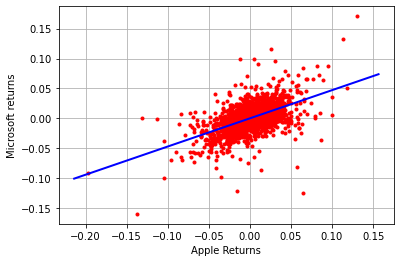

In [24]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot returns of AAPL and MSFT
plt.plot(return_data['AAPL'], return_data['MSFT'], 'r.')

# Add an axis to the plot
ax = plt.axis()

# Initialize `x`
x = np.linspace(ax[0], ax[1] + 0.01)

# Plot the regression line
plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

# Customize the plot
plt.grid(True)
plt.axis('tight')
plt.xlabel('Apple Returns')
plt.ylabel('Microsoft returns')

# Show the plot
plt.show()

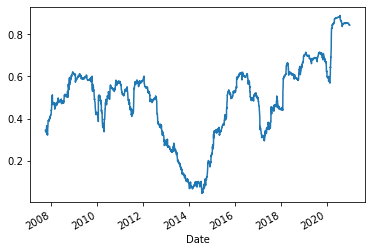

In [25]:
# Import matplotlib 
import matplotlib.pyplot as plt

# Plot the rolling correlation
return_data['MSFT'].rolling(window=252).corr(return_data['AAPL']).plot()

# Show the plot
plt.show()

In [26]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg   long_mavg  positions
Date                                                 
2006-10-02     0.0    2.673571    2.673571        NaN
2006-10-03     0.0    2.659643    2.659643        0.0
2006-10-04     0.0    2.670476    2.670476        0.0
2006-10-05     0.0    2.670982    2.670982        0.0
2006-10-06     0.0    2.666929    2.666929        0.0
...            ...         ...         ...        ...
2020-12-24     1.0  120.578000  118.223525        0.0
2020-12-28     1.0  121.112250  118.489800        0.0
2020-12-29     1.0  121.762500  118.699475        0.0
2020-12-30     1.0  122.386250  118.925550        0.0
2020-12-31     1.0  122.942500  119.125175        0.0

[3588 rows x 4 columns]


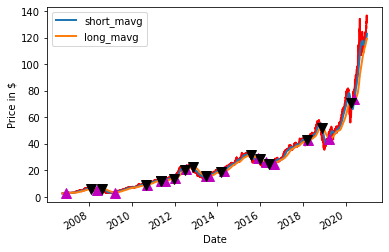

In [27]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [28]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

            AAPL  holdings      cash     total  returns
Date                                                   
2006-10-02   0.0       0.0  100000.0  100000.0      NaN
2006-10-03   0.0       0.0  100000.0  100000.0      0.0
2006-10-04   0.0       0.0  100000.0  100000.0      0.0
2006-10-05   0.0       0.0  100000.0  100000.0      0.0
2006-10-06   0.0       0.0  100000.0  100000.0      0.0


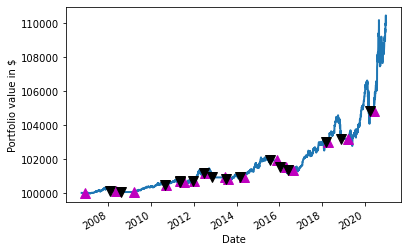

In [30]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()